### Set Graph State

In [20]:
# set graph state
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

class AgentState(TypedDict):
    """The state of our agent."""
    question: str
    certainty_score: int
    search_results: list
    web_score: str
    repo_name: str
    generation: str
    
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

### 사용자 질문에 대한 LLM의 답변 신뢰도 점검

In [21]:
# check certainty about LLM's answer
def check_certainty(state: AgentState) -> AgentState:
    """Evaluate certainty score for the query."""
    question = state["question"]
    class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")
    
    certrainty_scorer = llm.with_structured_output(CertaintyScoreResponse)
    
    print("---CHECKING LLM's CERTAINTY")
    score_reponse = certrainty_scorer.invoke(question)
    
    return {
        "certainty_score": score_reponse.score
    }
    
def route_based_on_certainty(state: AgentState) -> Literal["web_search", "direct_response"]:
    """Route to appropriate node based on certainty score."""
    score = state["certainty_score"]
    
    if score != 100:
        print("---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH")
        return "web_search"
    else:
        print("---LLM IS CERTAIN SO IT WILL GENERATE ANSWER DIRECTLY")
        return "direct_response"

In [22]:
question = "LangGraph로 rag를 구축하는 방법"
class CertaintyScoreResponse(BaseModel):
    score: int = Field(description="Certainty score from 1 to 100. Hihger is better.")

certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

print("---CHECKING LLM's CERTAINTY")
score_response = certainty_scorer.invoke(question)
score_response

---CHECKING LLM's CERTAINTY


CertaintyScoreResponse(score=85)

### LLM이 스스로 답변할 수 있는 경우의 노드

In [23]:
def direct_response(state: AgentState):
    question = state['question']
    result = llm.invoke(question)
    return {'generation': result.content}

### 웹 검색 기반의 답변 가능 여부 판단

In [24]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

def web_search(state: AgentState) -> AgentState:
    """ 
    Perform web search and evaluate results
    """
    TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
    os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
    
    # get original question
    question = state['question']
    
    search_tool = TavilySearchResults(max_results=3)
    search_results = search_tool.invoke(question)
    
    class answer_availability(BaseModel):
        """binady score for answer availability"""
        binary_score: str = Field(description="""
                                  If web search result can solve the user's ask, answer 'yes'.
                                  If not, answer 'no'.""")
    
    evaluator = llm.with_structured_output(answer_availability)
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate if these search results can answer the user's question with a simple yes/no."),
        ("user", """
         Question: {question}
         Search Results: {results}
         Can these results answer the question adequately?
         """)
    ])
    print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")
    evaluation = evaluator.invoke(
        eval_prompt.format(
            question=question, results="\n".join(f"- {result['content']}" for result in search_results)
        )
    )
    
    return {
        "search_results": search_results,
        "web_score": evaluation.binary_score
    }

### 웹 검색으로 해결 가능하지 여부 판단

In [25]:
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate

TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

question = "autorag github에서 명시된 설치 방법을 알려줘"
search_tool = TavilySearchResults(max_results=3)
search_results = search_tool.invoke(question)

class answer_availability(BaseModel):
    """binary score for answer availability"""
    binary_score: str = Field(description="""
                              If web search result can solbe the user's ask, answer 'yes'.
                              If user's ask is related with github or search results are insufficient, answer 'no'.""")
    
evaluator = llm.with_structured_output(answer_availability)
eval_prompt = ChatPromptTemplate.from_messages([
    ("system", """
     Evaluate if these search results can answer the user's question with a simple yes/no.
     If user ask github info, then it is not sufficient with web search so you should answer with no.
     """),
    ("user", """
     Question: {question}
     Search Results: {results}
     Can these results answer the question adequately?
     """)
])

print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")

evaluation = evaluator.invoke(
    eval_prompt.format(
        question=question, results="\n".join(f"- {result['content']}" for result in search_results)
    )
)

---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK


In [26]:
evaluation

answer_availability(binary_score='no')

### 웹 검색 결과로 해결 가능/불가능 여부로 다음 노드 라우팅하는 함수 정의

In [49]:
def route_after_search(state: AgentState) -> Literal['generate', 'github_search']:
    """ 
    Route based on search evaluation
    """
    if state['web_score'] == 'yes':
        print("---DECISION: 웹 검색 결과로 결과로 해결 가능합니다.")
        return 'web_generate'
    else:
        print("---DECISION: 웹 검색 결과로 해결 불가능합니다. 깃헙을 찾아보겠습니다.")
        return "github_search"

### 웹 검색 기반 답변 노드

In [50]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def web_generate(state: AgentState):
    question = state["question"]
    web_results = state["search_results"]
    def format_web_results(results):
        formatted = []
        for i, result in enumerate(results, 1):
            formatted.append(f"Source {i}:\nURL: {result['url']}\nContent: {result['content']}\n")
        return "\n".join(formatted)
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates comprehensive answers based on web search results.
         Use the provided search results to answer the user's question.
         Make sure to synthesize information from multiple sources when possible.
         If the search results don't contain enough information to fully answer the question, acknowledge this limitation."""),
        ("user", """Qeustion: {question}
         
         Search Results:
         {web_results}
         
         Please provide a detailed answer based on these search results. Answer in Korean
         """)
    ])
    
    chain = (
        {
            "question": lambda x: x['question'],
            "web_results": lambda x: format_web_results(x['web_results'])
        }
        | prompt
        | llm
        | StrOutputParser()
    )
    
    # execute the chain
    print("---웹 검색 결과 기반 답변 생성중...")
    response = chain.invoke({
        "question": question,
        "web_results": web_results
    })
    return {
        "generation": response
    }
    

### 깃헙 레포 정보를 가져오는 함수

In [51]:
from langchain_community.document_loaders import GithubFileLoader
from chromadb.config import Settings
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [58]:
def git_loader(repo, branch_name):
    loader = GithubFileLoader(
        repo=repo,              # repo the name
        branch=branch_name,     # the branch name
        access_token = keyring.get_password('github', 'key_for_windows'),
        github_api_url = 'https://api.github.com',
        file_filter = lambda file_path: file_path.endswith(
            ".md",
        ),      # load all markdowns files.
    )
    documents = loader.load()
    return documents

def git_vector_embedding(repo_name):
    client = chromadb.Client(Settings(
        is_peristent=True,
        persis_directory='./chroma_db'
    ))
    
    collection_name = repo_name.split("/")[1]
    
    # check if collection already exists
    existing_collections = client.list_collections()
    if collection_name in [col.name for col in existing_collections]:
        print(f"Loading existing collection for {collection_name}")
        # Load existing collection
        vectorstore = Chroma(
            client=client,
            collection_name=collection_name,
            embedding_function=OpenAIEmbeddings()
        )
        
    else:
        print(f"Creating new collection for {collection_name}")
        # create new collection with documents
        try:
            git_docs = git_loader(repo_name, "master")
        except:
            git_docs = git_loader(repo_name, "main")
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=50
        )
        doc_splits = text_splitter.split_documents(git_docs)
        
        vectorstore = Chroma.from_documents(
            documents=doc_splits,
            collection_name=collection_name,
            embedding=OpenAIEmbeddings(),
            client=client
        )
    return vectorstore
        

### 깃헙 레포 정보 기반의 답변 생성 노드

In [53]:
from langchain import hub 

def github_generate(state: AgentState) -> AgentState:
    """ 
    Find relevant Github repositories for the user's question.
    """
    class GithubRepo(BaseModel):
        """Best matching Github repository"""
        repo_name: str = Field(description="Full repository name in format 'owner/repo'")
    
    quesion = state['question']
    
    # 1. perform targeted web search for Github repositories
    search_tool = TavilySearchResults(max_results=5)
    search_results = search_tool.invoke(
        f"github repository {quesion} site:github.com"
    )
    
    # 2. Extract and evaluate repositories from search results
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert at indentifying the most relevant Gihub repository.
         Analyze the search results and identify the SINGLE MOST RELEVANT Github repository.
         Return ONLY the repository name in the format 'owner/repo."""),
        ("user", """
         Qeustion: {question}
         Search Results: {results}""")
    ])
    
    repo_extractor = llm.with_structured_output(GithubRepo)
    
    best_repo = repo_extractor.invoke(
        eval_prompt.format(
            quesion=quesion,
            results="\n\n".join(f"URL: {result['url']}\nContent: {result['content']}"
                                for result in search_results)
        )
    )
    repo_name = best_repo.repo_name
    vectorstore = git_vector_embedding(repo_name)
    retriever = vectorstore.as_retriever()
    prompt = hub.pull('rlm/rag-prompt')
    
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    print("---GITHUB REPO 검색 결과 기반의 답변 생성중")
    result = rag_chain.invoke(question)
    return {
        'generation': result
    }

### 그래프 구축

In [54]:
# create the graph
from langgraph.graph import StateGraph, START, END

# initialize graph
workflow = StateGraph(AgentState)

# add all nodes
workflow.add_node("check_certainty", check_certainty)
workflow.add_node('direct_response', direct_response)
workflow.add_node('web_search', web_search)
workflow.add_node('web_generate', web_generate)
workflow.add_node('github_generate', github_generate)

# add edges
# start flow
workflow.add_edge(START, 'check_certainty')

# add conditional edges based on certainty score
workflow.add_conditional_edges(
    'check_certainty',
    route_based_on_certainty,
    {
        "web_search": "web_search",
        "direct_response": "direct_response"
    }
)

# add conditional edges after web search
workflow.add_conditional_edges(
    "web_search",
    route_after_search,
    {
        "web_generate": "web_generate",
        "github_generate": "github_generate"
    }
)

# add edges to END
workflow.add_edge("direct_response", END)
workflow.add_edge("web_generate", END)
workflow.add_edge("github_generate", END)

# compile the graph
app = workflow.compile()

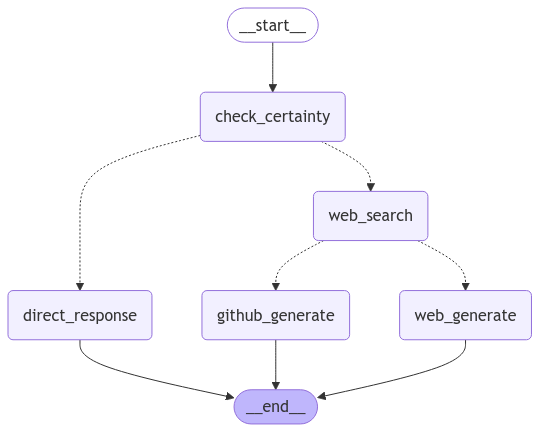

In [55]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [56]:
import pprint

inputs = {
    "question": "Yolo v5를 실행하는 방법에 대해서 알아? 정확한 코드를 줄래?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint('---')
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CHECKING LLM's CERTAINTY
---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH
"Output from node 'check_certainty':"
'---'
{'certainty_score': 90}
'\n---\n'
---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK
---DECISION: 웹 검색 결과로 결과로 해결 가능합니다.
"Output from node 'web_search':"
'---'
{ 'search_results': [ { 'content': '[Python] YOLO v5 사용하기 (로컬, 내컴퓨터에서) : 네이버 '
                                   '블로그 [Python] YOLO v5 사용하기 (로컬, 내컴퓨터에서) '
                                   'https://wandb.ai/onlineinference/YOLO/reports/YOLOv5-Object-Detection-on-Windows-Step-By-Step-Tutorial---VmlldzoxMDQwNzk4 '
                                   '- YOLO v5 설치하기 다음 링크에 들어가서 YOLO v5 다운로드 하기 '
                                   '그러면 C:\\yolo5-master 폴더 생기고 여기에 코드 내용이 '
                                   '풀린다. yolo 폴더 안에 보면\xa0requirements.txt 파일이 '
                                   '있다. '
                                   'https://wandb.ai/onlineinference/YOLO/reports/Collect-and-Label-Images-to-Train-a-